## PYTHON VERSION

In [1]:
import sys
print(sys.version)

## Heston Stochastic Volatility Model

\begin{align*}
dX_t&=(r-\frac{V_t}{2})dt+\sqrt{V_t}dW_t, \quad X_0=x, \\
dV_t&=\kappa(\theta-V_t)dt+\eta \sqrt{V_t} d\overline{W}_t, \quad V_0=v,
\end{align*}

where: 

- $S=S_0e^X,$ 
- $\kappa,\theta,\eta,v \in \mathbb{R}_+,$
- $r,x\in \mathbb{R},$
- $\rho \in[-1,1],$
- $\overline{W}=\rho W +\sqrt{1-\rho^2}\tilde{W}$, $W$ and $\tilde{W}$ are indipendent Brownian motions.

In [2]:
#import libraries
import time
import numpy as np
import math
from matplotlib import style
from matplotlib import pyplot as plt
from math import exp
from numpy.lib.scimath  import sqrt
from scipy.integrate import quad
import scipy.stats as stats
import statistics
#-----------------------------------------------
import warnings
warnings.filterwarnings("ignore")
#-----------------------------------------------

# to plot the results in the notebook:
%matplotlib inline

In [3]:
#-----------------------------------------------
################################################
# Euler Monte Carlo method for a call option   #
# under the Heston stochastic volatility model.#
################################################
#-----------------------------------------------

price_trajectories = []             #MC array
def EMC_Call_Option(S,V,r,T,delta_t,N,K,k,theta,eta,rho):
    M = N**2                            #simulations
    payoff_array       = []
    discount_factor    = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, M):

        S_old = S
        V_old = V
        
        for i in range(0, N):
            xi = np.random.normal(0,sqrt(delta_t)) 
            xj = np.random.normal(0,sqrt(delta_t))
            
            xk = rho*xi + sqrt(1-rho**2)*xj

            S_new = S_old + r*S_old*delta_t + S_old*sqrt(max(V_old,0))*xi
                
            V_new = V_old + k*(theta-V_old)*delta_t + eta*sqrt(max(V_old,0))*xk

            S_old = S_new
            V_old = V_new
            

        price_trajectories.append(S_new)
        payoff=max(S_new-K,0)
        payoff_array.append(payoff)

    # Computing price
    payoff_array = np.array(payoff_array, dtype=float) 
    price = np.sum(discount_factor*payoff_array)/M
    print("Call Option Price      : %.4f" % price)

    # Statistics
    variance = np.var(discount_factor*payoff_array)
    sd = np.std(discount_factor*payoff_array)
    # Variance Estimator
    varest=sum((price-discount_factor*payoff_array)**2)/(M-1)
    # Root Mean Square Error
    RMSE=sqrt(varest)/sqrt(M)
    # 95% C.I. uses 1.96 z-value
    CI = [price - (1.96*sd/sqrt(float(M))),
          price + (1.96*sd/sqrt(float(M)))]

    # Toc
    elapsed = time.time() - t

    #Print
    print("Variance               : %.4f" % variance)
    print("Standard Deviation     : %.4f" % sd)
    print("95% Confidence Interval:", CI) 
    print("Variance Estimator     : %.4f" % varest)
    print("Root Mean Square Error : %.4f" % RMSE)
    print("Run time               : %.4f" % elapsed)

    # Plot
    sims=range(1,M+1)
    #fig = plt.figure(figsize=(40,6))
    #plt.plot(sims,price_trajectories,color = 'red')
    #plt.suptitle('Maturity Prices', fontsize=35)
    #plt.xlabel('Simulation #', fontsize = 30)
    #plt.ylabel('Price', fontsize= 30)
    #plt.grid(True)
     
    return price

In [4]:
def plot_trajectories(T,delta_t,M,price_trajectories):
        """uses matplotlib to plot the trajectory
        of each individual stock stored in earlier
        trajectory array"""
        print("Creating Plot...")
        #use numpy to plot 
        np_price_trajectories = np.array(price_trajectories, dtype=float)
        times = np.linspace(0, T, M)

        #style/plot/barrier line
        #style.use('dark_background')
        style.use('classic')

        fig = plt.figure(figsize=(30,6))
        ax1 = plt.subplot2grid((1,1),(0,0))
        #for sublist in np_price_trajectories:
        #   if np.max(sublist) > 0:
        #        ax1.plot(times,sublist,color = 'cyan')
        #    else:
        ax1.plot(times,np_price_trajectories,color = 'red')
        #plt.axhline(y=8,xmin=0,xmax=T,linewidth=2, color = 'red', label = 'Barrier')

        #rotate and add grid
        #for label in ax1.xaxis.get_ticklabels():
        #    label.set_rotation(45)
        ax1.grid(True)
      
        #plotting stuff
        plt.xticks(np.arange(0, T+delta_t, .1))
        plt.xlabel('Time (in years)', fontsize = 30)
        plt.ylabel('Return', fontsize= 30)
        plt.show()

## Input Data
<UL>
    <LI>Spot price $S_0=100$, interest rate $r=0\%$.</LI>
    <LI>Maturity $T=1$, strike price $K=80.$</LI>
    <LI><B>Heston Parameters</B>: $\kappa=1,\theta=v=9\%,\eta=1, \rho=-0.3$.</LI>
</UL>

In [5]:
################################################
# Input data.                                  #
################################################
S         = 100                             #spot price
V         = 0.09                            #initial volatility
X         = np.log(S)                       #ln(S_0)
r         = 0                               #interest rate
T         = 1                               #maturity
k         = 1
theta     = 0.09
eta       = 1
rho       = -0.3                            #correlation
N         = 100                             #number of discrete time points
delta_t   = T / N                           #length of interval partition 

In [6]:
K         = 80                              #strike price(i)

C_80      = EMC_Call_Option(S,V,r,T,delta_t,N,K,k,theta,eta,rho)

Call Option Price      : 23.3585
Variance               : 557.4107
Standard Deviation     : 23.6095
95% Confidence Interval: [22.895736183264752, 23.821230384956692]
Variance Estimator     : 557.4664
Root Mean Square Error : 0.2361
Run time               : 154.4490


Creating Plot...


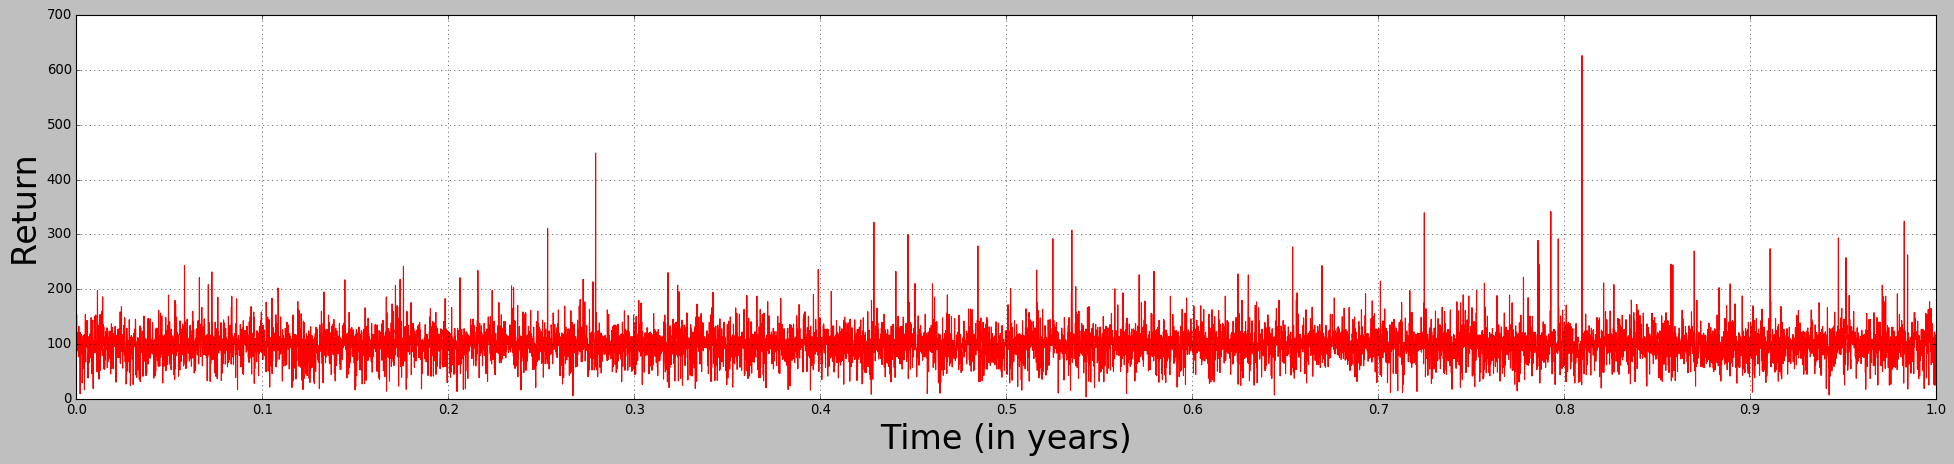

In [7]:
plot_trajectories(T,delta_t,N**2,price_trajectories)

## Approximating the Distribution of the Underlyings
The <b>Heston Stochastic Volatility Model</b> doesn't impy that the underlying assets follow a <b>log-normal distribution</b>: 
- Red Curve $\rightarrow$ Gamma Distribution
- Green Curve $\rightarrow$ Normal Distribuiton

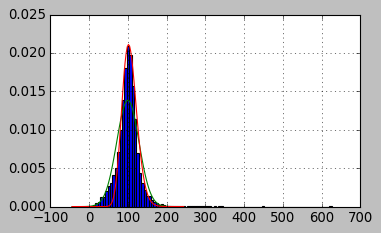

In [8]:
bins=100
style.use('classic')
#plt.hist(price_trajectories,bins)
fig = plt.figure(figsize=(5,3))
plt.hist(price_trajectories,bins,density=True)

mu = statistics.mean(price_trajectories)
sigma = statistics.stdev(price_trajectories)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)

plt.plot(x,stats.norm.pdf(x, mu, sigma))

plt.plot(x,stats.gamma.pdf(x, a=30, scale=3.5))

plt.grid(True)
plt.show()